In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.models import Config2D, StarDist2D, StarDistData2D

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

np.random.seed(42)
lbl_cmap = random_label_cmap()

Using TensorFlow backend.


In [2]:
X = sorted(glob('/home/qzt/data/dsb2018/train_sub/images/*.tif'))
Y = sorted(glob('/home/qzt/data/dsb2018/train_sub/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))
img_X = list(map(imread,X))
img_Y = list(map(imread,Y))
n_channel = 1 if img_X[0].ndim == 2 else img_X[0].shape[-1]

In [4]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

img2_X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(img_X)]
img2_Y = [fill_label_holes(y) for y in tqdm(img_Y)]


100%|██████████| 5/5 [00:00<00:00, 503.14it/s]

100%|██████████| 5/5 [00:00<00:00, 126.77it/s]


In [8]:
# assert len(img2_X) > 1, "not enough training data"
# rng = np.random.RandomState(42)
# ind = rng.permutation(len(img2_X))
# n_val = max(1, int(round(0.15 * len(ind))))
# ind_train, ind_val = ind[:-n_val], ind[-n_val:]

In [11]:
#manual assign train/val index for debugging
ind_train = [0,1,2,3]
ind_val = [4]

In [13]:
X_val, Y_val = [img2_X[i] for i in ind_val]  , [img2_Y[i] for i in ind_val]
X_trn, Y_trn = [img2_X[i] for i in ind_train], [img2_Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:   5
- training:         4
- validation:       1


In [21]:
i = 3
print(Path(X[i]).name)

c75139ef0546d2240b37afb3219eb74a06b7977818697d5c3138796472483af3.tif


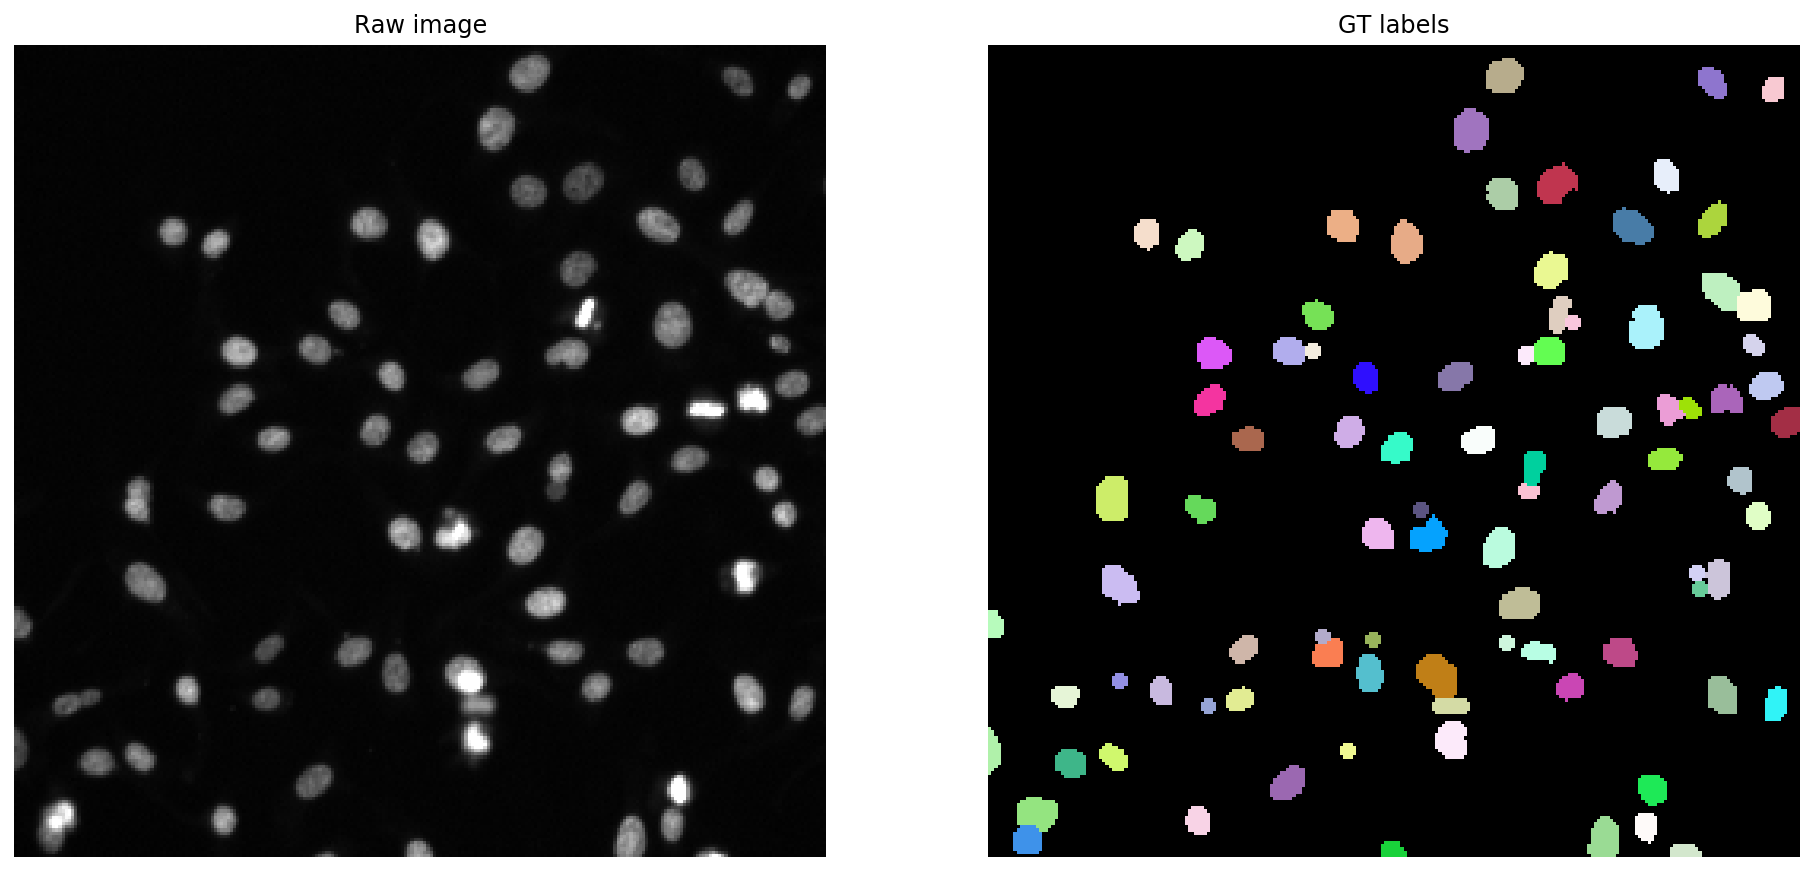

In [22]:
img, lbl = X_trn[i], Y_trn[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;